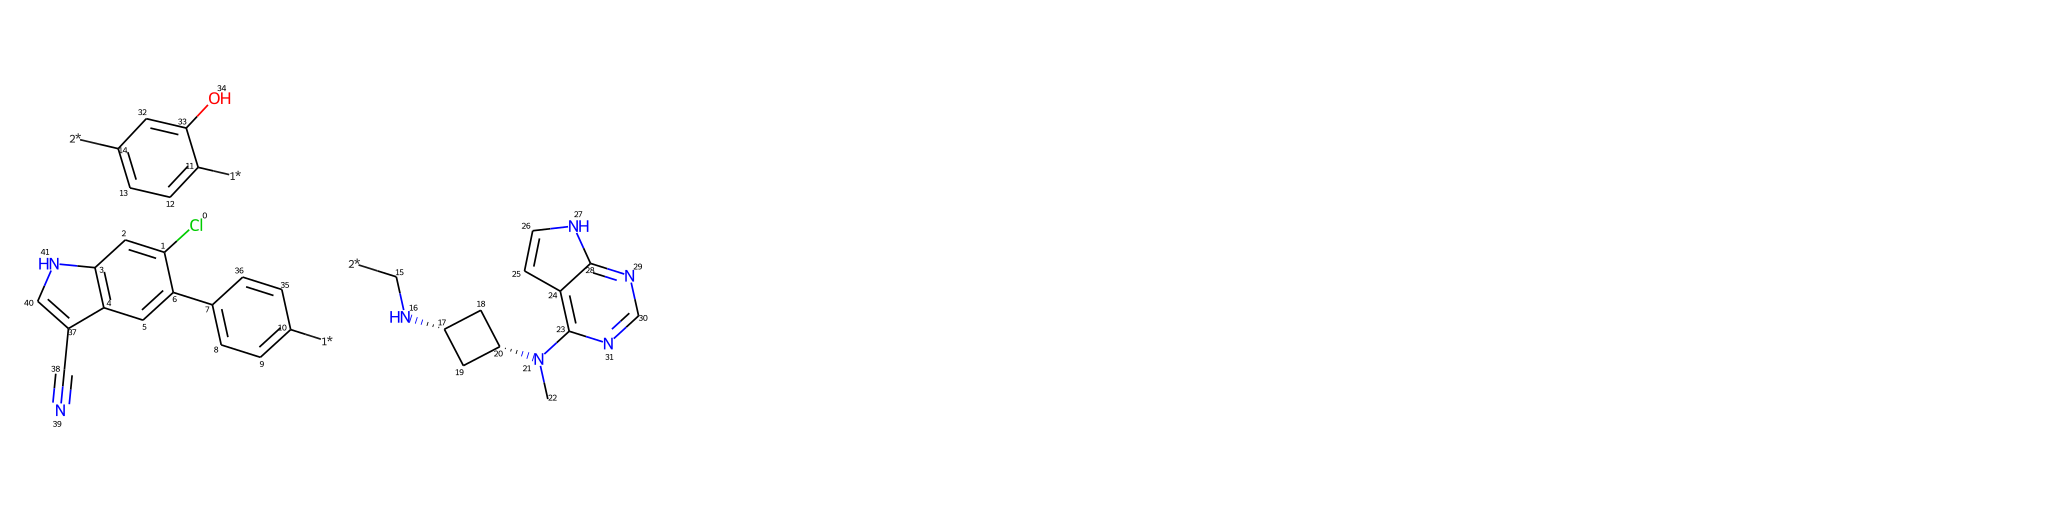

frag1_smiles:  [*:1]c1ccc(-c2cc3c(C#N)c[nH]c3cc2Cl)cc1
frag2_smiles:  [*:1]c1ccc([*:2])cc1O
frag3_smiles:  [*:2]CN[C@H]1C[C@@H](N(C)c2ncnc3[nH]ccc23)C1


In [13]:
from rdkit import Chem
from my_toolset.my_utils import get_mol, partial, mapper
import random
import os, sys
from pathlib import Path, PurePath
import operator
from my_toolset.drawing_utils import *
import copy,re

def mol_with_atom_index(mol, Idx=None, start=1):
    mol=get_mol(mol)
    mol = copy.deepcopy(mol)
    for atom in mol.GetAtoms():
        if Idx != None:
            # atom.SetAtomMapNum(Idx)
            atom.SetProp("atomNote", str(Idx))
        else:
            atom.SetProp("atomNote", str(atom.GetIdx()+start))
    return mol


def fragment_on_atom_pairs(mol, atom_pairs):
    bonds = []
    bond_dirs = {}
    dummy_labels = []
    
    label = 1
    for a1, a2 in atom_pairs:
        bond = mol.GetBondBetweenAtoms(a1, a2)
        if bond.IsInRing():
            raise ValueError("Cannot fragment a ring bond (between %d and %d)"
                             % (a1, a2))
            
        bonds.append(bond.GetIdx())
        bond_dir = bond.GetBondDir()
        #print("bond is", bond_dir)

        if bond.GetBeginAtomIdx() == a1:
            # dummy_labels.append( (label, label+1) )
            dummy_labels.append( (label, label) )
            if bond_dir == Chem.BondDir.ENDDOWNRIGHT:
                bond_dirs[(a1, label+1)] = Chem.BondDir.ENDDOWNRIGHT
                bond_dirs[(a2, label  )] = Chem.BondDir.ENDUPRIGHT
            elif bond_dir == Chem.BondDir.ENDUPRIGHT:
                bond_dirs[(a1, label+1)] = Chem.BondDir.ENDUPRIGHT
                bond_dirs[(a2, label  )] = Chem.BondDir.ENDDOWNRIGHT
        else:
            # swapped
            # dummy_labels.append( (label+1, label) )
            dummy_labels.append( (label, label) )
            if bond_dir == Chem.BondDir.ENDUPRIGHT:
                bond_dirs[(a1, label+1)] = Chem.BondDir.ENDDOWNRIGHT
                bond_dirs[(a2, label  )] = Chem.BondDir.ENDUPRIGHT
            elif bond_dir == Chem.BondDir.ENDDOWNRIGHT:
                bond_dirs[(a1, label+1)] = Chem.BondDir.ENDUPRIGHT
                bond_dirs[(a2, label  )] = Chem.BondDir.ENDDOWNRIGHT
        
        label += 1

    ## print("bond_dirs", bond_dirs)
    ## print("bonds:", bonds)
    ## print("dummyLabels:", dummy_labels)
    fragmented_mol = Chem.FragmentOnBonds(mol, bonds, dummyLabels=dummy_labels)
    ## print("fragmented_mol:", cansmiles(fragmented_mol))

    dummy_pairs = [[] for _ in atom_pairs]
    for atom in fragmented_mol.GetAtoms():
        if atom.GetAtomicNum() == 0:
            label = atom.GetIsotope()
            # i = label // 2 - 1
            # dummy_pairs[i].append(atom.GetIdx())
            # atom.SetIsotope(0)

            for bond in atom.GetBonds():
                other_atom_id = bond.GetOtherAtomIdx(atom.GetIdx())
                #print("look for", (other_atom_id, label))
                bond_dir = bond_dirs.get( (other_atom_id, label), None)
                #print("set to", bond_dir)
                if bond_dir is not None:
                    bond.SetBondDir(bond_dir)
                break
            else:
                raise AssertionError
    
    other_atom_table = {}
    # for a1, a2 in dummy_pairs:
    #     other_atom_table[a1] = a2
    #     other_atom_table[a2] = a1
    
    return fragmented_mol, other_atom_table  #dummy_pairs

def bondLabel(smi):
    pattern = r"\d\*"
    matches = re.findall(pattern, smi)
    for imatch in set(matches):
        # imatch_sp=imatch.split(':')
        newLabel=f"*:{imatch[0]}"
        smi=smi.replace(imatch,newLabel)
    return smi


smi="ClC1=CC2=C(C=C1C3=CC=C(C4=CC=C(CN[C@H](C5)C[C@H]5N(C)C6=C(C=CN7)C7=NC=N6)C=C4O)C=C3)C(C#N)=CN2"
mol=mol_with_atom_index(smi, Idx=None, start=0)
png,svg=show_mols([mol])
# display(svg)
fragmented_mol, other_atom_table=fragment_on_atom_pairs(mol, [[10,11],[14,15]])
png,svg=show_mols([fragmented_mol])
display(svg)
frag1_indices, frag2_indices, frag3_indices = Chem.GetMolFrags(fragmented_mol)
frag1_smiles = Chem.MolFragmentToSmiles(fragmented_mol, frag1_indices, isomericSmiles=True)
frag2_smiles = Chem.MolFragmentToSmiles(fragmented_mol, frag2_indices, isomericSmiles=True)
frag3_smiles = Chem.MolFragmentToSmiles(fragmented_mol, frag3_indices, isomericSmiles=True)
print(f"frag1_smiles:  {bondLabel(frag1_smiles)}")
print(f"frag2_smiles:  {bondLabel(frag2_smiles)}")
print(f"frag3_smiles:  {bondLabel(frag3_smiles)}")
